# Pokersters Fantasy Football Notebook
Lets do the data thang

In [2]:
!pip install sleeper-api-wrapper
!pip install matplotlib-label-lines

### Initialize

In [3]:
from sleeper_wrapper import League, Stats, Players
import pandas as pd
import numpy as np
import io
import csv
import re
import pickle
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from labellines import labelLine, labelLines

league_id = 723630813350014976
league = League(league_id)
players = Players()
# players_df = pd.read_pickle('./sleeper_players.pkl')
# ffa_proj_df = pd.read_pickle("./ffa_proj.pkl")

In [4]:
# import player projection data from spreadsheet
with open('sleeper_players.pkl', 'wb') as file:
    ffa_proj_df = pd.read_csv('ffa_all_week7_10-19-2021.txt', sep='\t', index_col=False)
    ffa_proj_df['Player'] = ffa_proj_df['Player'].str.replace('.', '')
    ffa_proj_df['Player_Pos'] = ffa_proj_df['Player'] + ffa_proj_df['Position']
    # why is the abbr for vegas LVR rather than LV??? annoying
    ffa_proj_df['Team'].replace({'LVR': 'LV', 'JAC': 'JAX'}, inplace=True)
    # convert defense player names from common name to abbreviated to match sleeper
    ffa_proj_df.to_pickle('./ffa_proj.pkl')

ffa_proj_df.head()

<ipython-input-4-5e2abefb024a>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  ffa_proj_df['Player'] = ffa_proj_df['Player'].str.replace('.', '')


,Player,Team,Position,Floor,Mean,Ceiling,SD,Risk,Drop Off,Tier,ADP,Player_Pos
0,Patrick Mahomes,KC,QB,24.3,25.4,26.3,0.880,3.15,0.477,1.0,NaN,Patrick MahomesQB
1,Kyler Murray,ARI,QB,22.7,25.0,27.8,2.130,3.78,1.720,2.0,NaN,Kyler MurrayQB
2,Lamar Jackson,BAL,QB,22.1,23.2,24.2,0.852,3.03,1.340,3.0,NaN,Lamar JacksonQB
3,Aaron Rodgers,GB,QB,20.6,21.9,24.9,1.850,3.87,0.234,3.0,NaN,Aaron RodgersQB
4,Tom Brady,TB,QB,20.8,21.7,22.1,0.575,3.29,0.055,3.0,NaN,Tom BradyQB


In [5]:
# Import players from sleeper, run this block to get updated players data
players_dict = players.get_all_players()
players_df = pd.DataFrame(players_dict).transpose()
players_df['full_name'] = players_df['full_name'].str.replace('.', '')
players_df['full_name_pos'] = players_df['full_name'] + players_df['position']
players_df = players_df.reset_index()
players_df = players_df.merge(ffa_proj_df, left_on='full_name_pos', right_on='Player_Pos', how='left')
players_df['player_id'] = players_df['index'].fillna(players_df['Team'])
players_df = players_df.set_index('player_id')
players_df = players_df.drop(columns=['index'])
for i in players_df.loc[players_df['fantasy_positions'].apply(lambda x: True if x and 'DEF' in x else False).tolist()].index.tolist():
    dst_matches = ffa_proj_df[(ffa_proj_df['Position'] == 'DST') & (ffa_proj_df['Team'] == i)]
    if not dst_matches.empty:
        players_df.loc[i, ffa_proj_df.columns] = dst_matches.iloc[0]
players_df[ffa_proj_df.columns] = players_df[ffa_proj_df.columns].fillna(0)
players_df.to_pickle('./sleeper_players.pkl')
players_df.head()

<ipython-input-5-fa3af1a1ef9c>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  players_df['full_name'] = players_df['full_name'].str.replace('.', '')


,gsis_id,stats_id,birth_date,years_exp,sportradar_id,injury_status,injury_start_date,birth_city,high_school,depth_chart_order,...,Position,Floor,Mean,Ceiling,SD,Risk,Drop Off,Tier,ADP,Player_Pos
player_id,,,,,,,,,,,,,,,,,,,,,
2103,None,None,1991-04-22,1,4cd4976e-e230-4935-ad3f-c12876a41350,None,None,None,None,None,...,0,0.0,0.0,0.0,0.000,0.00,0.000,0.0,0.0,0
6250,None,None,None,0,9ff46edb-988f-4c8a-ad56-0502808ca1a6,NA,None,None,None,None,...,0,0.0,0.0,0.0,0.000,0.00,0.000,0.0,0.0,0
4116,00-0033922,None,1993-12-10,3,a2b6e1f9-1f06-45e3-b6e9-79ec8490e5ef,None,None,None,None,None,...,0,0.0,0.0,0.0,0.000,0.00,0.000,0.0,0.0,0
6177,00-0035656,None,1996-08-09,2,757c55e1-2f3a-41d2-a211-16bf577a1586,None,None,None,Parkway Central (MO),2,...,0,0.0,0.0,0.0,0.000,0.00,0.000,0.0,0.0,0
5870,00-0035710,879981,1997-05-27,2,0042266b-cb28-4012-bfd2-06650badad97,None,None,None,Charlotte Latin (NC),1,...,QB,15.8,16.8,18.1,0.961,5.21,0.575,8.0,0.0,Daniel JonesQB


In [6]:
ffa_proj_df.head()

,Player,Team,Position,Floor,Mean,Ceiling,SD,Risk,Drop Off,Tier,ADP,Player_Pos
0,Patrick Mahomes,KC,QB,24.3,25.4,26.3,0.880,3.15,0.477,1.0,NaN,Patrick MahomesQB
1,Kyler Murray,ARI,QB,22.7,25.0,27.8,2.130,3.78,1.720,2.0,NaN,Kyler MurrayQB
2,Lamar Jackson,BAL,QB,22.1,23.2,24.2,0.852,3.03,1.340,3.0,NaN,Lamar JacksonQB
3,Aaron Rodgers,GB,QB,20.6,21.9,24.9,1.850,3.87,0.234,3.0,NaN,Aaron RodgersQB
4,Tom Brady,TB,QB,20.8,21.7,22.1,0.575,3.29,0.055,3.0,NaN,Tom BradyQB


### Get Leaguemates data

In [7]:
users = league.get_users()
users_df = pd.DataFrame(users)
users_df = users_df.set_index(users_df.columns[0])
users_df

,settings,metadata,league_id,is_owner,is_bot,display_name,avatar
user_id,,,,,,,
375038190341611520,None,"{'team_name': 'The Trolley Problems', 'mention...",723630813350014976,None,False,thinkfast86,3c7def417a4613d104ae66403af0e0e7
607043401484926976,None,"{'team_name': 'Gaskin Dobbins', 'show_mascots'...",723630813350014976,None,False,mmasison,e36c64e702e2db846c91eb439a13df6a
608864437348163584,None,"{'team_name': 'Je Ne Saquon', 'mention_pn': 'o...",723630813350014976,None,False,TheVermanator,None
723630209273765888,None,"{'team_name': 'Hit Quads like Saquon', 'mentio...",723630813350014976,True,False,benslayer68,None
723633476015857664,None,"{'team_name': 'Tom Brady's Son', 'mention_pn':...",723630813350014976,None,False,dlaffs,6e0dc0a80e7d0560d8ef4777d3a90b16
723650381690769408,None,"{'team_name': '10,000 Rats', 'show_mascots': '...",723630813350014976,None,False,mikulis,ea2334c4e55f4c7d1d1544544eae3f54
723683736822059008,None,"{'mascot_item_type_id_leg_6': 'dogecoin', 'mas...",723630813350014976,None,False,schlaich,0008e9a0c13d1ebb16549afa8e884ef3
723753245457104896,None,"{'team_name': 'Questionably Mediocre ', 'menti...",723630813350014976,None,False,izzyfoshizzy8,15d7cf259bc30eab8f6120f45f652fb6
723755503108349952,None,"{'team_name': 'Mahomes’ Modern Life', 'mention...",723630813350014976,None,False,hunterm19,6c08fd9d771cdc622d9c57632a02aa6d


In [8]:
rosters = league.get_rosters()
rosters_df = pd.DataFrame(rosters)
# if someone doesn't have a team name, use username
rosters_df['team_name'] = rosters_df['owner_id'].apply(lambda x: users_df.loc[x]['metadata']['team_name'] if 'team_name' in users_df.loc[x]['metadata'] else users_df.loc[x]['display_name'])
rosters_df.head()

,taxi,starters,settings,roster_id,reserve,players,player_map,owner_id,metadata,league_id,co_owners,team_name
0,None,"[4881, 5000, 6813, 2216, 5045, 1466, 6151, 59,...","{'wins': 9, 'waiver_position': 8, 'waiver_budg...",1,[4951],"[1266, 1466, 1992, 2216, 4068, 4663, 4881, 495...",None,723630209273765888,"{'streak': '4W', 'record': 'WWWWWLLLWWWW'}",723630813350014976,None,Hit Quads like Saquon
1,None,"[421, 1535, 7608, 7525, 4039, 4531, 7526, 391,...","{'wins': 9, 'waiver_position': 11, 'waiver_bud...",2,[5892],"[1535, 391, 4029, 4039, 421, 4217, 4531, 536, ...",None,375038190341611520,"{'streak': '2W', 'record': 'WWWLWWWLWLWW', 'p_...",723630813350014976,None,The Trolley Problems
2,None,"[2306, 5980, 1408, 7601, 1825, 1339, 6789, 422...","{'wins': 5, 'waiver_position': 6, 'waiver_budg...",3,[3199],"[1339, 1408, 1825, 2306, 3199, 4131, 4227, 515...",None,607043401484926976,"{'streak': '2L', 'record': 'WWLWLLLLWWLL'}",723630813350014976,None,Gaskin Dobbins
3,None,"[167, 4035, 5850, 4981, 4983, 5012, 5846, 1099...","{'wins': 6, 'waiver_position': 4, 'waiver_budg...",4,[4273],"[1049, 1099, 1144, 167, 3209, 4035, 4273, 4962...",None,723633476015857664,"{'streak': '2L', 'record': 'LLWLWWWWLWLL'}",723630813350014976,None,Tom Brady's Son
4,None,"[2028, 4018, 5890, 1352, 5927, 4602, 5947, 650...","{'wins': 5, 'waiver_position': 2, 'waiver_budg...",5,[5038],"[1067, 1352, 2028, 3225, 4018, 4602, 4866, 495...",None,608864437348163584,"{'streak': '2L', 'record': 'LLLLWWWWLWLL'}",723630813350014976,None,Je Ne Saquon


In [9]:
for col in ['Floor','Mean','Ceiling','Risk']:
    rosters_df['Starters_' + col] = rosters_df['starters'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']][col]))

rosters_df['Starters_Variance'] = rosters_df['starters'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']]['SD']**2))
rosters_df['Starters_SD'] = rosters_df['Starters_Variance']**(1/2)
rosters_df

,taxi,starters,settings,roster_id,reserve,players,player_map,owner_id,metadata,league_id,co_owners,team_name,Starters_Floor,Starters_Mean,Starters_Ceiling,Starters_Risk,Starters_Variance,Starters_SD
0,None,"[4881, 5000, 6813, 2216, 5045, 1466, 6151, 59,...","{'wins': 9, 'waiver_position': 8, 'waiver_budg...",1,[4951],"[1266, 1466, 1992, 2216, 4068, 4663, 4881, 495...",None,723630209273765888,"{'streak': '4W', 'record': 'WWWWWLLLWWWW'}",723630813350014976,None,Hit Quads like Saquon,96.09,106.79,117.39,32.62,11.102024,3.331970
1,None,"[421, 1535, 7608, 7525, 4039, 4531, 7526, 391,...","{'wins': 9, 'waiver_position': 11, 'waiver_bud...",2,[5892],"[1535, 391, 4029, 4039, 421, 4217, 4531, 536, ...",None,375038190341611520,"{'streak': '2W', 'record': 'WWWLWWWLWLWW', 'p_...",723630813350014976,None,The Trolley Problems,84.77,104.43,118.37,52.18,29.017201,5.386762
2,None,"[2306, 5980, 1408, 7601, 1825, 1339, 6789, 422...","{'wins': 5, 'waiver_position': 6, 'waiver_budg...",3,[3199],"[1339, 1408, 1825, 2306, 3199, 4131, 4227, 515...",None,607043401484926976,"{'streak': '2L', 'record': 'WWLWLLLLWWLL'}",723630813350014976,None,Gaskin Dobbins,56.76,68.58,78.65,39.06,17.547516,4.188976
3,None,"[167, 4035, 5850, 4981, 4983, 5012, 5846, 1099...","{'wins': 6, 'waiver_position': 4, 'waiver_budg...",4,[4273],"[1049, 1099, 1144, 167, 3209, 4035, 4273, 4962...",None,723633476015857664,"{'streak': '2L', 'record': 'LLWLWWWWLWLL'}",723630813350014976,None,Tom Brady's Son,102.60,115.24,127.40,40.48,16.456701,4.056686
4,None,"[2028, 4018, 5890, 1352, 5927, 4602, 5947, 650...","{'wins': 5, 'waiver_position': 2, 'waiver_budg...",5,[5038],"[1067, 1352, 2028, 3225, 4018, 4602, 4866, 495...",None,608864437348163584,"{'streak': '2L', 'record': 'LLLLWWWWLWLL'}",723630813350014976,None,Je Ne Saquon,80.97,90.81,100.32,38.59,10.772850,3.282202
5,None,"[6768, 7594, 5916, 2078, 7564, 6826, 5859, 466...","{'wins': 8, 'waiver_position': 9, 'waiver_budg...",6,[4034],"[1689, 2078, 2320, 2505, 4034, 4036, 4666, 498...",None,723650381690769408,"{'streak': '4W', 'record': 'LWWWWLLLWWWW', 'p_...",723630813350014976,None,"10,000 Rats",84.95,94.58,102.44,34.22,9.794746,3.129656
6,None,"[24, 3969, 0, 2133, 7571, 3214, 7547, 1433, 0]","{'wins': 6, 'waiver_position': 7, 'waiver_budg...",7,[7543],"[1433, 2133, 2251, 2309, 24, 2449, 3214, 3294,...",None,723683736822059008,"{'streak': '4W', 'restrict_pn_scoring_starters...",723630813350014976,None,The Zany Zebras,63.54,73.28,80.65,30.01,11.051860,3.324434
7,None,"[96, 2431, 6694, 5872, 1426, 4066, 7561, 6650,...","{'wins': 4, 'waiver_position': 5, 'waiver_budg...",8,[5248],"[1426, 1476, 2168, 2431, 4066, 5248, 5872, 590...",None,723753245457104896,"{'streak': '4L', 'record': 'LLWWLLWWLLLL'}",723630813350014976,None,Questionably Mediocre,82.41,94.68,105.85,38.21,15.968319,3.996038
8,None,"[4046, 6790, 4137, 3321, 4037, 5857, 830, 1264...","{'wins': 6, 'waiver_position': 1, 'waiver_budg...",9,None,"[1264, 2460, 3242, 3321, 4037, 4046, 4137, 435...",None,723755503108349952,"{'streak': '2W', 'record': 'WWLLLWLWLLWW'}",723630813350014976,None,Mahomes’ Modern Life,95.79,104.71,113.21,33.83,9.061119,3.010169
9,None,"[6904, 956, 6945, 2374, 6989, 7553, 4993, 5095...","{'wins': 6, 'waiver_position': 12, 'waiver_bud...",10,[6820],"[1479, 1833, 2374, 3164, 4149, 4993, 5095, 593...",None,724012989333708800,"{'streak': '3L', 'restrict_pn_scoring_starters...",723630813350014976,None,Belichick Yo Self,75.71,86.30,96.39,43.36,14.606429,3.821836


In [10]:
plt.rcParams['figure.figsize'] = [30, 15]

In [11]:
players_df.loc[[x for x in rosters_df.iloc[11]['starters'] if x != '0']].loc[:, ['full_name', 'Mean']]

,full_name,Mean
player_id,,
5849,Kyler Murray,25.00
3198,Derrick Henry,20.00
4199,Aaron Jones,16.40
5848,Marquise Brown,12.60
2197,Brandin Cooks,12.10
3271,Tyler Higbee,7.78
5549,Darrel Williams,12.30
17,Matt Prater,0.00
CAR,NaN,7.42


<AxesSubplot:xlabel='team_name'>

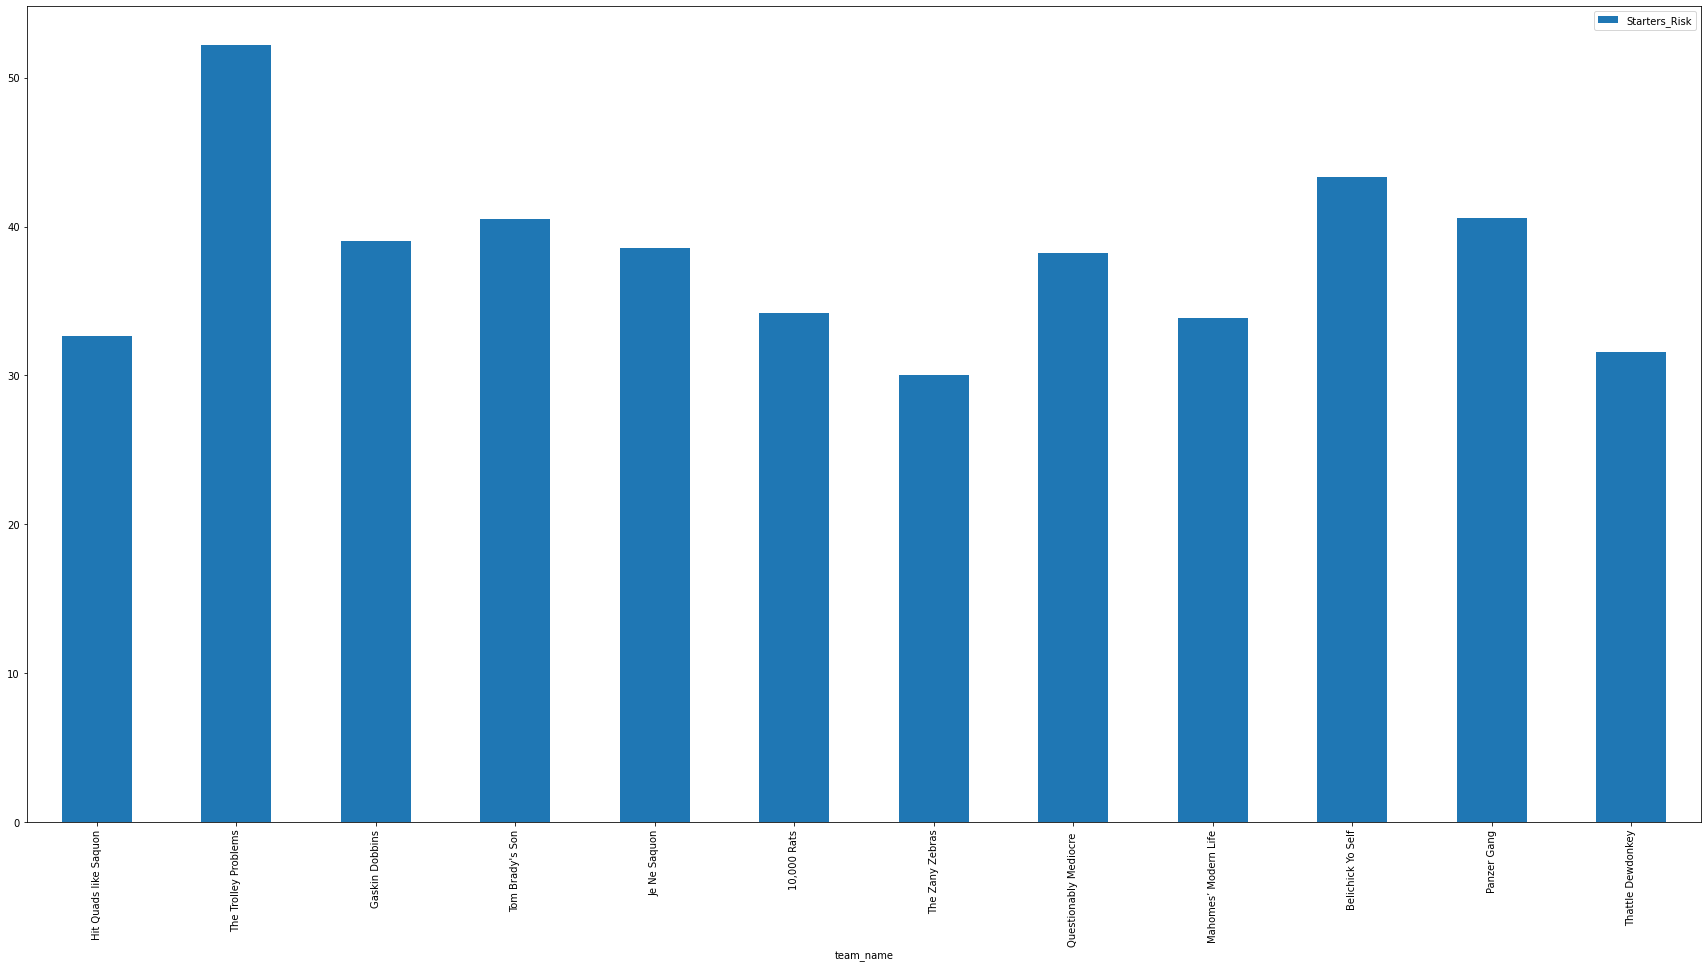

In [12]:
rosters_df.plot.bar(x='team_name', y='Starters_Risk')

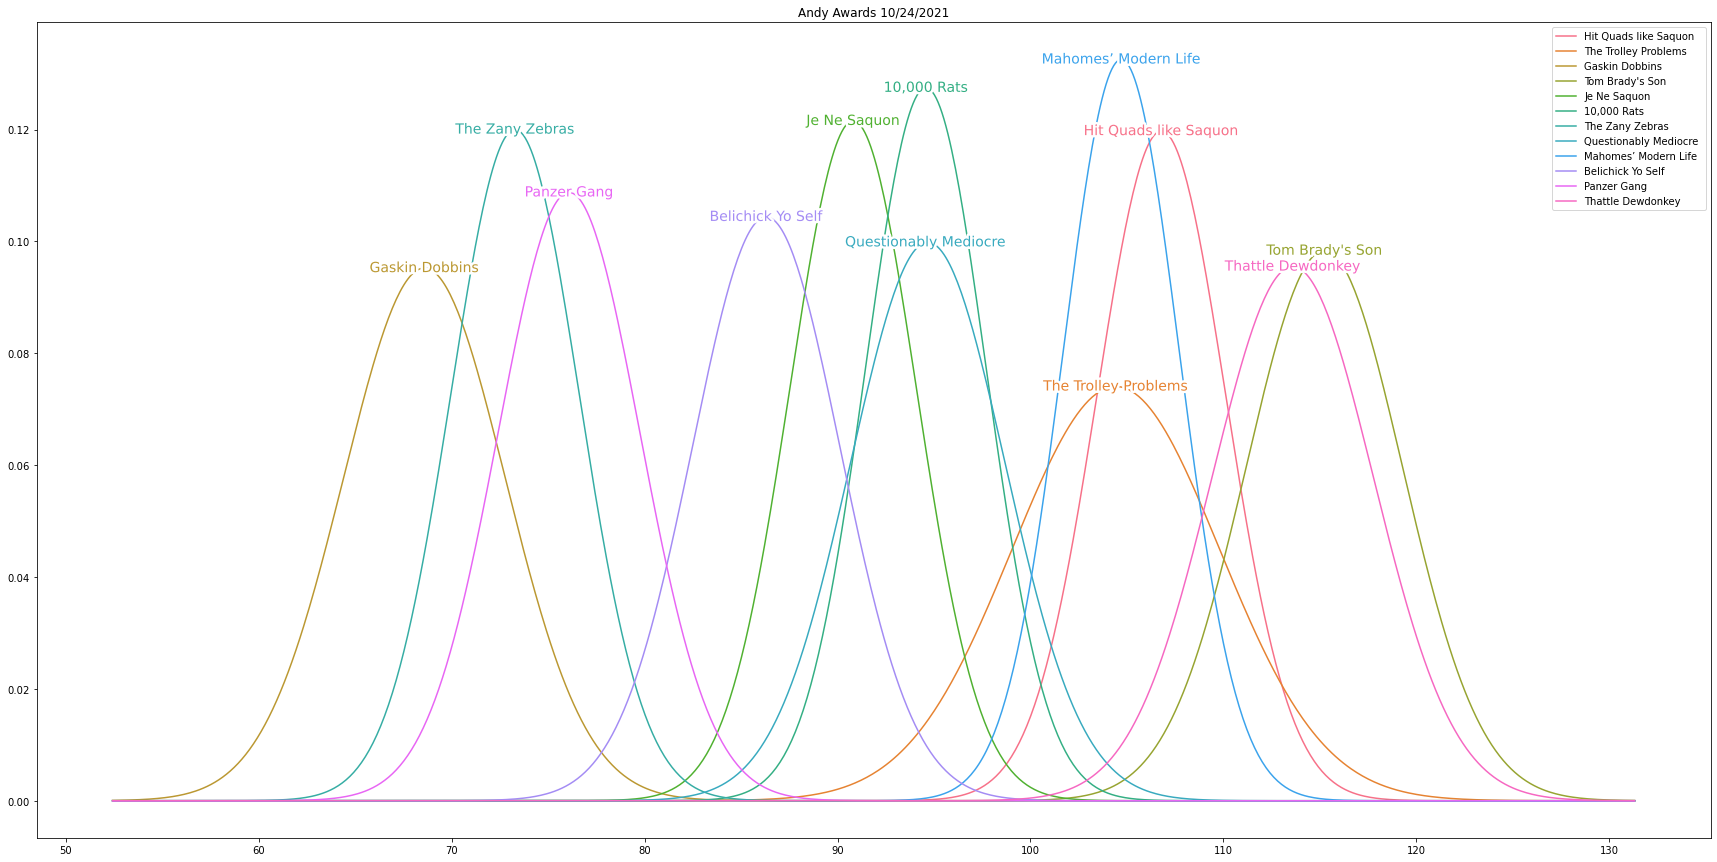

In [14]:
plt.rcParams['figure.figsize'] = [30, 15]
fig, ax1 = plt.subplots()
colors = sns.color_palette("husl", rosters_df.shape[0])
ax1.set_prop_cycle('color', colors)
x_axis = np.arange(rosters_df['Starters_Mean'].min() - 3*rosters_df['Starters_SD'].max(), rosters_df['Starters_Mean'].max() + 3*rosters_df['Starters_SD'].max(), .1)

for roster in rosters_df.iterrows():  
    plt.plot(x_axis, norm.pdf(x_axis, roster[1]['Starters_Mean'], roster[1]['Starters_SD']), label=roster[1]['team_name'])
    
labelLines(plt.gca().get_lines(), fontsize=14, align=True,  xvals = rosters_df['Starters_Mean'], zorder=2.5)
plt.legend()

ax1.title.set_text('Andy Awards 10/24/2021')
plt.show()

In [29]:
rosters_df.loc[:, ['team_name', 'Starters_Mean', 'Starters_SD']].sort_values(by='Starters_Mean')

,team_name,Starters_Mean,Starters_SD
2,Gaskin Dobbins,68.58,4.188976
6,The Zany Zebras,73.28,3.324434
10,Panzer Gang,76.08,3.668032
9,Belichick Yo Self,86.30,3.821836
4,Je Ne Saquon,90.81,3.282202
5,"10,000 Rats",94.58,3.129656
7,Questionably Mediocre,94.68,3.996038
1,The Trolley Problems,104.43,5.386762
8,Mahomes’ Modern Life,104.71,3.010169
0,Hit Quads like Saquon,106.79,3.331970


In [30]:
rosters_df.loc[:, ['team_name', 'Starters_Ceiling', 'Starters_Floor']].sort_values(by='Starters_Floor')

,team_name,Starters_Ceiling,Starters_Floor
2,Gaskin Dobbins,78.65,56.76
6,The Zany Zebras,80.65,63.54
10,Panzer Gang,86.76,67.10
9,Belichick Yo Self,96.39,75.71
4,Je Ne Saquon,100.32,80.97
7,Questionably Mediocre,105.85,82.41
1,The Trolley Problems,118.37,84.77
5,"10,000 Rats",102.44,84.95
8,Mahomes’ Modern Life,113.21,95.79
0,Hit Quads like Saquon,117.39,96.09


In [ ]:
matchups = league.get_matchups(2)

In [ ]:
matchups[0]

### Import SI fantasy projections 2021

#### Sanitize SI Fantasy Football Rankings 2021

I didn't actually end up using this, the data was too gross

In [ ]:
with open('2021 SI Fantasy Football Rankings & Projections - Rosters.csv', newline='') as readfile:
    with open('SI_Projections_2021_Sanitizied.csv', 'w', newline='') as writefile:
        reader = csv.reader(readfile)
        writer = csv.writer(writefile)
        for row in reader:
            if not row[0].isupper(): # remove team name 
                if row[0] == '' and row[2]:
                    row[0] = 'Players'
                    if row[1] == '' and row[2]:
                        row[1] = 'Rank'
                writer.writerow(row)

In [ ]:
projectionsDF = pd.DataFrame()
l = []

with open('SI_Projections_2021_Sanitizied.csv', newline='') as fp:
    line = fp.readline()
    buffer = io.StringIO(line)
    while line:
        if line[0] != ',':
            buffer.write(line)
        elif buffer.tell():
            buffer.seek(0)
            curDF = pd.read_csv(buffer)
            curDF = curDF.loc[:, ~curDF.columns.str.contains('^Unnamed')]
#             projectionsDF = projectionsDF.append(curDF, ignore_index=True)
            l.append(curDF)
            buffer.close()
            curDF
            buffer = io.StringIO()
        line = fp.readline()
        
projectionsDF = pd.concat(l)